<a href="https://colab.research.google.com/github/1306minyoung/data/blob/main/7_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##손실곡선

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

train_scaled = train_input / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

4422102/4422102 [==============================] - 0s 0us/step


In [12]:
#모델을 함수로 정의
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer: #케라스 층을 추가했다면 은닉층 뒤에 또 하나의 층을 추가하라는 뜻
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

model = model_fn()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               78500     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
#모델 훈련
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
hist = model.fit(train_scaled, train_target, epochs=5, verbose=0)

여기서 verbose는 훈련과정을 얼마나 자세히 출력할 것인지 조절

기본값은 1. 에포크마다 진행막대와 함께 손실등의 지표가 출력됨.

2로 설정하면 진행막대를 빼고 출력.

0으로 설정하면 훈련과정은 나타나지 않음

In [14]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy'])


history 객체엔 훈련 측정값이 담겨있는 history 딕셔너리가 들어있음.

손실과 정확도가 포함되어 있는데, 케라스는 기본적으로 에포크마다 손실을 계산함.

정확도느 compile()메서드에서 metrics 매개변수에 'accuracy'를 추가했기 때문에 포함됨

손실과 정확도는 에포크마다 계산한 값이 순서대로 나열된 단순한 리스트라서 matplotlib을 통해 그래프를 그릴 수 있음

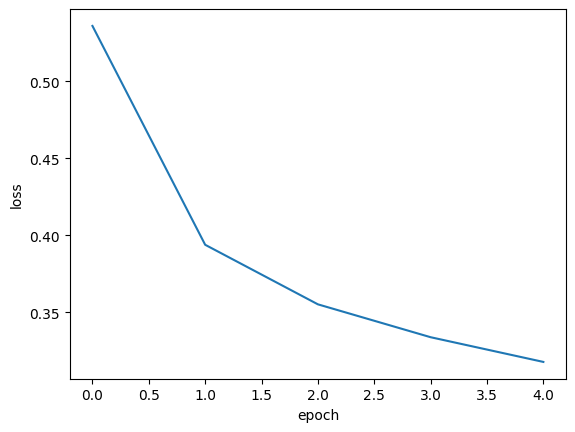

In [15]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

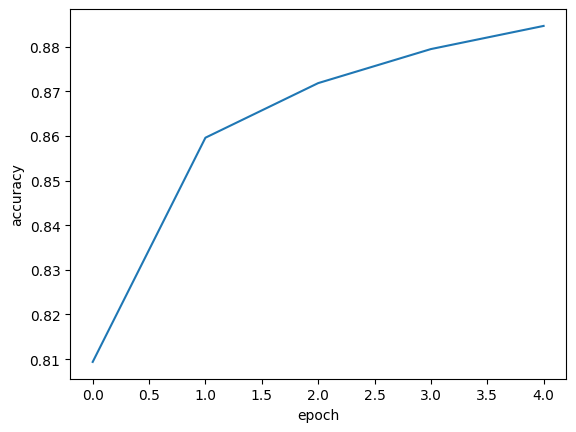

In [16]:
plt.plot(hist.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [18]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

hist1= model.fit(train_scaled, train_target, epochs=20, verbose=0)

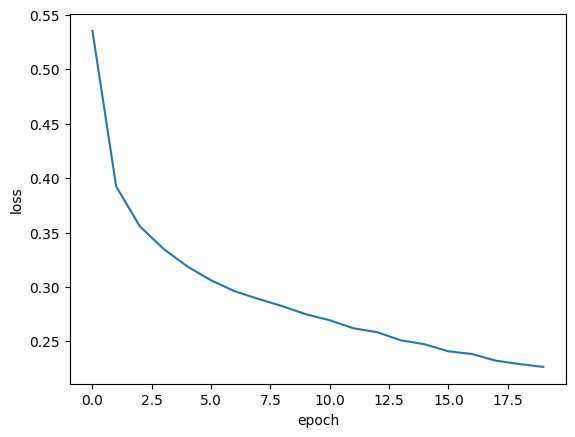

In [19]:
plt.plot(hist1.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

에포크에 따른 과대적합, 과소적합을 파악하려면 훈련 세트에 대한 점수 뿐만 아니라 검증 세트에 대한 점수도 필요.

그러므로 앞에서처럼 훈련세트의 손실만 그려서는 안됨.

이를 위해 필요한게 **검증 손실**

최적의 매개변수

기울기를 계산하고 이를 기반으로 매개변수의 값을조금씩 조정하는 과정 반복

기울기 0이 되면 현 매개변수가 최적값이구나~

또는 반복회수에 제한이 있다면 그 제한 안에서 최소의 기울기를 가지는 매개변수를 최적값으로 설정

In [20]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

In [21]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


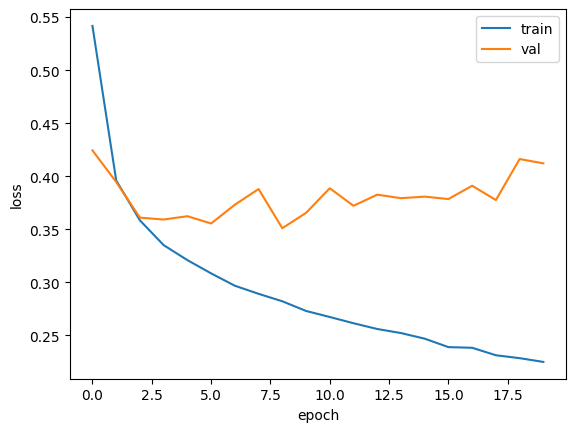

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

검증손실은 감소하다가 점점 상승, 훈련 손실은 계속 감소하니 전형적인 과대적합 모델 만들어짐

검증 손실이 상승하는 시점을 가능한 뒤로 늦추면 검증 세트에 대한 손실이 줄어들 뿐만 아니라 검증 세트에 대한 정확도도 증가할 것

우선 옵티마이저 하이퍼파라미터를 조정해 과대 적합을 완화시켜보자


In [25]:
model = model_fn()
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
adam_lr = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=adam_lr, loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

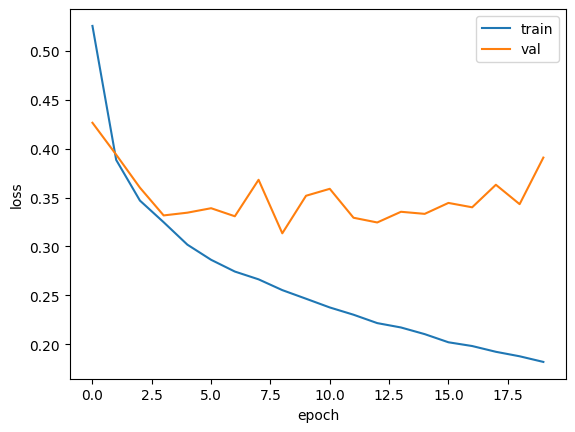

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

##드롭아웃

신경망에서 사용하는 대표적인 규제 방법

훈련과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼내(즉 해당 뉴런의 출력을 0으로 마들어)과대적합을 막음

반면에 드롭아웃을 하지않는 뉴런의 출력은 1/ (1-r)만큼 증가시켜 출력의 종합이 같도록 함

여기서 r은 드롭할 뉴런의 비율로서 하이퍼 파라미터

반면에 검증 또는 평가시 모든 뉴런 사용

드롭아웃이 과대적합을 막을 수 있는 이유

1. 이전 츠의 일부 뉴런이 랜덤하게 꺼지면 특저 뉴런에 과대하게 의존하는 것을 줄일 수 있고, 모든 입력에 대해 주의를 기울여야 함. 즉 일부 뉴런의 출력이 없을 수도 있다는 걸 감안하면 신경망은 더 안정적인 예측을 만들 수 있을 것

2. 드롭 아웃을 적용해 훈련하는 것은 마치 2개의 신경망을 앙상블 하는 것처럼 적용될 수 있

In [26]:
model = model_fn(keras.layers.Dropout(0.3))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_16 (Dense)            (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


텐서플로와 케라스는 모델을 평가와 예측에 사용될 때는 자동으로 드롭아웃을 적용하지 않음

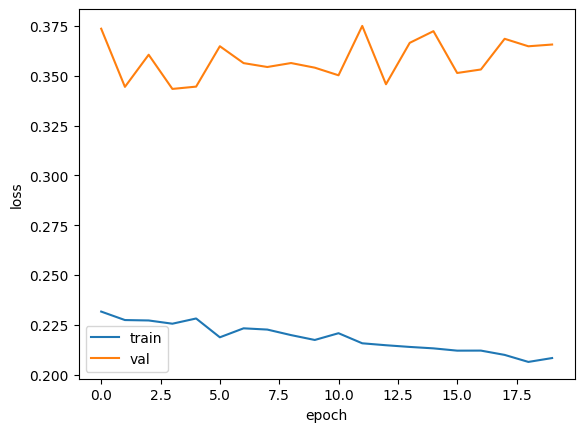

In [30]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()


In [29]:
import numpy as np
min_loss = np.argmin(history.history['val_loss'])
print(min_loss)

2


##모델 저장과 복원

만들어진 모델을 나중에 다시 사용하려면 모델을 저장해야

케라스 모델은 훈련된 모델의 파라미터를 저장하는 save_weights()메서드를 제공

In [31]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=10, verbose=0,
                    validation_data=(val_scaled, val_target))

In [32]:
model.save_weights('model-weights.h5')

모델 구조와 모델 파라미터를 함께 저장하는 save() 메서드 제공.

In [33]:
model.save('model-whole.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
!ls -al *.h5
#h5가 갖고있는 모든 파일 디렉토리 내용 표시

-rw-r--r-- 1 root root 333320 Nov  6 03:26 model-weights.h5
-rw-r--r-- 1 root root 981176 Nov  6 03:26 model-whole.h5


훈련을 하지않은 새로운 모델을 만들고 model-weights.h5파일에서 훈련된 모델 파라미터를 읽어서 사용

모델 파라미터만 보관하고 있으므로 저장했던 모델과 정확히 같은 구조를 가져야함

In [35]:
model = model_fn(keras.layers.Dropout(0.3))

model.load_weights('model-weights.h5')

predict(): 샘플마다 모든 클래스에 대한 확률을 반환

argmax()의 axis=-1은 배열의 마지막 차원을 따라 최대값의 인덱스를 선택

2차원이므로 마지막 차원은 1이 됨

In [36]:
import numpy as np

val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

375/375 [==============================] - 1s 2ms/step
0.8779166666666667


손실을 출력하기 위해 compile()메서드를 먼저 실행해야

fit()메서드는 실행할 필요 없음. 이미 훈련한 모델의 파라미터를 불러와 사용하기 때문.

모델 전체를 파일에서 읽고 모델의 검증 정확도 확인

keras.models.load_model() 함수는 모델 파라미터 뿐만 아니라 모델 구조, 옵티마이저 상태까지 모두 복원하니까 compile() 없이 evaluate()사용 가능.

In [37]:
model = keras.models.load_model('model-whole.h5')

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3285 - accuracy: 0.8779


[0.32846659421920776, 0.877916693687439]

##콜백

모델을 두번씩 훈련하지 않고 한번에 끝낼 수 있는 방법: 콜백 이용

fit() 메서드의 callbacks 매개변수에 list로 전달해 사용

ModelCheckpoint 콜백은 기본적으로 에포크마다 모델 저장

save_best_only=True: 가장 낮은 검증 점수를 만드는 모델을 저장 가능

monitor:  모니터링할 지표 지정. 기본값은 val_loss로 검증손실 관찰


In [38]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5',
                                                save_best_only=True)

model.fit(train_scaled, train_target, epochs=20, verbose=0,
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb])

In [39]:
model = keras.models.load_model('best-model.h5')

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3216 - accuracy: 0.8842


[0.32159215211868286, 0.8842499852180481]

조기종료

과대적합이 시작하기 전에 훈련을 미리 중지하는 것

에포크 횟수를 제한하는 역할이지만, 모델이 과대적합 되는 것을 막아주기 떄문에 규제 방법 중 하나로 생각할 수도 있음.

restore_best_weights:  True면 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌림

monitor:  모니터링할 지표 지정.기본값 val_loss

early_stopping 콜백을 ModelCheckpoint콜백과 함께 사용 -> 가장 낮은 검증 손실의 모델을 파일에 저장,

검증 손실이 다시 상승할 때 훈련을 중지.


또한 훈련 중지 후 현재 모델의 파라미터를 최상의 파라미터로 되돌림

In [41]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

In [42]:
print(early_stopping_cb.stopped_epoch)

8


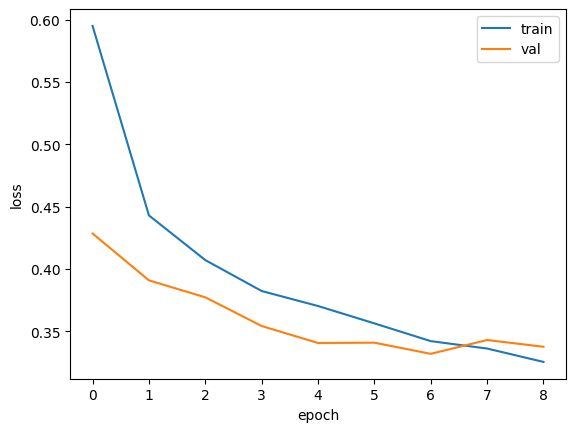

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [40]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 2s 5ms/step - loss: 0.3216 - accuracy: 0.8842


[0.32159215211868286, 0.8842499852180481]